In [3]:
# ============================================================
# IMPORTS
# ============================================================

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numba import njit
import time


# ============================================================
# STATIC MODEL FOR SCALE-FREE NETWORKS
# ============================================================

def build_sf_static_model(N, m, gamma, seed=0):
    """
    Generate a scale-free network using the static model.

    Parameters
    ----------
    N : int
        Number of nodes.
    m : int
        Controls the average degree (<k> ≈ 2m).
    gamma : float
        Degree exponent of the scale-free distribution.
        If gamma = inf, the network becomes homogeneous.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    G : networkx.Graph
        Undirected graph generated with the static model.
    """

    rng = np.random.default_rng(seed)

    # Weight exponent for the static model
    alpha = 0.0 if np.isinf(gamma) else 1.0 / (gamma - 1.0)

    # Node weights
    idx = np.arange(1, N + 1, dtype=float)
    weights = idx ** (-alpha)
    prob = weights / weights.sum()

    # Cumulative distribution for sampling
    cdf = np.cumsum(prob)
    cdf[-1] = 1.0  # ensure numerical stability

    target_edges = m * N
    edges = set()

    # Rejection sampling of edges
    while len(edges) < target_edges:

        u1 = rng.random(50000)
        u2 = rng.random(50000)

        nodes_a = np.searchsorted(cdf, u1)
        nodes_b = np.searchsorted(cdf, u2)

        for i, j in zip(nodes_a, nodes_b):

            if i == j:
                continue  # avoid self-loops

            if i > j:
                i, j = j, i  # enforce ordering for undirected edges

            edges.add((i, j))

            if len(edges) >= target_edges:
                break

    G = nx.Graph()
    G.add_nodes_from(range(N))
    G.add_edges_from(edges)

    return G


In [4]:
# ============================================================
# CSR CONVERSION FOR FAST NUMERICAL SIMULATION
# ============================================================

def graph_to_csr_undirected(G):
    """
    Convert an undirected NetworkX graph into
    Compressed Sparse Row (CSR) format.

    The CSR representation allows efficient neighbor
    traversal inside Numba-accelerated simulations.

    Parameters
    ----------
    G : networkx.Graph
        Undirected graph.

    Returns
    -------
    indptr : np.ndarray (int64)
        Index pointer array (length N+1).
    indices : np.ndarray (int32)
        Concatenated neighbor indices.
    degree : np.ndarray (int32)
        Degree of each node.
    """

    N = G.number_of_nodes()

    # Degree of each node
    degree = np.array([G.degree(i) for i in range(N)], dtype=np.int32)

    # Build index pointer array
    indptr = np.zeros(N + 1, dtype=np.int64)
    indptr[1:] = np.cumsum(degree)

    # Allocate neighbor storage
    indices = np.empty(indptr[-1], dtype=np.int32)

    # Temporary cursor to fill adjacency
    cursor = indptr[:-1].copy()

    # Populate adjacency (undirected graph → symmetric entries)
    for u, v in G.edges():

        pos_u = cursor[u]
        indices[pos_u] = v
        cursor[u] += 1

        pos_v = cursor[v]
        indices[pos_v] = u
        cursor[v] += 1

    return indptr, indices, degree


In [5]:
# ============================================================
# BTW SANDPILE DYNAMICS ON NETWORKS
# ============================================================

@njit
def simulate_btw_fixed(indptr, indices, z_c, f, steps, transient, seed, active_nodes):
    """
    Simulate the Bak-Tang-Wiesenfeld sandpile dynamics
    on a network represented in CSR format.

    Parameters
    ----------
    indptr, indices : CSR representation of the graph
    z_c : array of node thresholds (typically equal to degree)
    f : float
        Dissipation probability during grain transfer
    steps : int
        Number of recorded driving steps
    transient : int
        Initial steps discarded to reach stationarity
    seed : int
        Random seed
    active_nodes : array
        Nodes with degree > 0 (eligible for driving)

    Returns
    -------
    sizes : array
        Avalanche sizes (total number of topplings)
    areas : array
        Number of distinct nodes toppled in each avalanche
    losses_all : array
        Number of dissipated grains per avalanche
    """

    np.random.seed(seed)

    N = len(z_c)

    # Current sand configuration
    z = np.zeros(N, dtype=np.int32)

    # Observables
    sizes = np.zeros(steps, dtype=np.int32)
    areas = np.zeros(steps, dtype=np.int32)
    losses_all = np.zeros(steps, dtype=np.int32)

    # Pre-allocated buffers for wave propagation
    current = np.empty(N, dtype=np.int32)
    next_wave = np.empty(N, dtype=np.int32)
    in_next = np.zeros(N, dtype=np.uint8)
    toppled = np.zeros(N, dtype=np.uint8)

    rec = 0  # index for recorded avalanches

    for step in range(steps + transient):

        # External driving: add one grain to a random active node
        node = active_nodes[np.random.randint(0, len(active_nodes))]
        z[node] += 1

        # Reset avalanche markers
        for i in range(N):
            toppled[i] = 0

        cur_len = 0

        # Check initial instability
        if z[node] >= z_c[node]:
            current[cur_len] = node
            cur_len += 1

        size = 0
        losses = 0

        # Avalanche propagation
        while cur_len > 0:

            next_len = 0

            for t in range(cur_len):

                i = current[t]

                # Topple while unstable
                while z[i] >= z_c[i]:

                    size += 1

                    if toppled[i] == 0:
                        toppled[i] = 1

                    z[i] -= z_c[i]

                    # Distribute grains to neighbors
                    for p in range(indptr[i], indptr[i + 1]):

                        if np.random.rand() < f:
                            losses += 1
                            continue

                        nb = indices[p]
                        z[nb] += 1

                        if z[nb] >= z_c[nb] and in_next[nb] == 0:
                            next_wave[next_len] = nb
                            in_next[nb] = 1
                            next_len += 1

                    # If still unstable, schedule again
                    if z[i] >= z_c[i] and in_next[i] == 0:
                        next_wave[next_len] = i
                        in_next[i] = 1
                        next_len += 1

            # Reset scheduling flags
            for j in range(next_len):
                in_next[next_wave[j]] = 0

            # Prepare next wave
            cur_len = next_len
            for j in range(cur_len):
                current[j] = next_wave[j]

        # Record observables after transient
        if step >= transient:

            area = 0
            for i in range(N):
                if toppled[i] == 1:
                    area += 1

            sizes[rec] = size
            areas[rec] = area
            losses_all[rec] = losses

            rec += 1

    return sizes, areas, losses_all


In [6]:
# ============================================================
# ANALYSIS UTILITIES
# ============================================================

def compute_ccdf(data):
    """
    Compute the complementary cumulative distribution function (CCDF).
    """
    x = np.sort(data)
    n = len(x)
    y = 1.0 - np.arange(n) / n
    return x, y


def estimate_tau_ccdf(data, s_min, s_max):
    """
    Estimate the avalanche size exponent tau from the CCDF
    within a selected scaling window.
    """

    data = data[data > 0]

    x = np.sort(data)
    n = len(x)
    y = 1.0 - np.arange(n) / n

    mask = (x >= s_min) & (x <= s_max)

    lx = np.log10(x[mask])
    ly = np.log10(y[mask])

    slope, _ = np.polyfit(lx, ly, 1)

    tau = 1 - slope

    return tau


In [7]:
# ============================================================
# GLOBAL SIMULATION PARAMETERS
# ============================================================

# --- Network parameters ---
N = 20000                 # Number of nodes
m = 2                     # Controls average degree (<k> ≈ 2m)
gamma = float("inf")      # Degree exponent (gamma = inf → homogeneous limit)

# --- Dynamical parameters ---
f = 1e-4                  # Dissipation probability per grain transfer
bulk_only = False         # If True, analyze only avalanches with zero dissipation

# --- Simulation parameters ---
steps = 200000            # Number of recorded avalanches
transient = 100000        # Transient steps discarded before measurements
seed = 42                 # Random seed for reproducibility


In [8]:
# ============================================================
# SINGLE SIMULATION: BASELINE CASE
# ============================================================

print("Building network...")
t0 = time.time()

G = build_sf_static_model(N, m, gamma, seed)

print("Network built in {:.2f} seconds".format(time.time() - t0))

# Convert graph to CSR format
indptr, indices, degree = graph_to_csr_undirected(G)
z_c = degree.astype(np.int32)

active_nodes = np.where(z_c > 0)[0].astype(np.int32)

print("Number of nodes:", N)
print("Mean degree:", degree.mean())
print("Isolated nodes:", (degree == 0).sum())

Building network...
Network built in 0.31 seconds
Number of nodes: 20000
Mean degree: 4.0
Isolated nodes: 378


In [9]:
# ------------------------------------------------------------
# Run BTW simulation
# ------------------------------------------------------------

print("Running simulation...")
t0 = time.time()

sizes, areas, losses = simulate_btw_fixed(
    indptr,
    indices,
    z_c,
    f,
    steps,
    transient,
    seed,
    active_nodes
)

print("Simulation completed in {:.2f} seconds".format(time.time() - t0))

Running simulation...
Simulation completed in 106.18 seconds


In [10]:

# ------------------------------------------------------------
# Post-processing
# ------------------------------------------------------------

mask_nonzero = sizes > 0

if bulk_only:
    mask_nonzero = mask_nonzero & (losses == 0)

sizes_filtered = sizes[mask_nonzero]

print("Total recorded avalanches:", len(sizes_filtered))
print("Maximum avalanche size:", sizes_filtered.max())
print("Mean avalanche size:", sizes_filtered.mean())

Total recorded avalanches: 88327
Maximum avalanche size: 413548
Mean avalanche size: 5572.062596940913


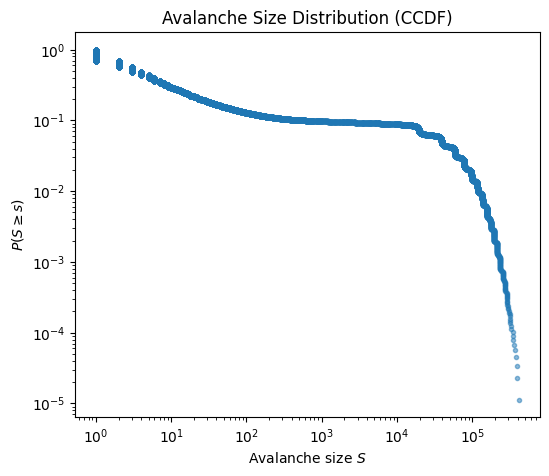

In [11]:
# ============================================================
# CCDF OF AVALANCHE SIZE (BASELINE)
# ============================================================

def compute_ccdf(data):
    x = np.sort(data)
    n = len(x)
    y = 1.0 - np.arange(n) / n
    return x, y

x, y = compute_ccdf(sizes_filtered)

plt.figure(figsize=(6,5))
plt.loglog(x, y, '.', alpha=0.5)

plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S \geq s)$")
plt.title("Avalanche Size Distribution (CCDF)")

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig1.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [37]:
# ============================================================
# DISSIPATION DEPENDENCE TEST (APPENDIX)
# ============================================================

f_values = [1e-3, 1e-4, 1e-5]
results_f = {}

for i, f_test in enumerate(f_values):

    print("\nRunning simulation with f =", f_test)

    sizes_tmp, areas_tmp, losses_tmp = simulate_btw_fixed(
        indptr,
        indices,
        z_c,
        f_test,
        steps,
        transient,
        seed + i,   
        active_nodes
    )

    sizes_tmp = sizes_tmp[sizes_tmp > 0]

    print("Total avalanches:", len(sizes_tmp))
    print("Max size:", sizes_tmp.max())

    results_f[f_test] = sizes_tmp



Running simulation with f = 0.001
Total avalanches: 88591
Max size: 39746

Running simulation with f = 0.0001
Total avalanches: 88485
Max size: 390962

Running simulation with f = 1e-05
Total avalanches: 88818
Max size: 4445590


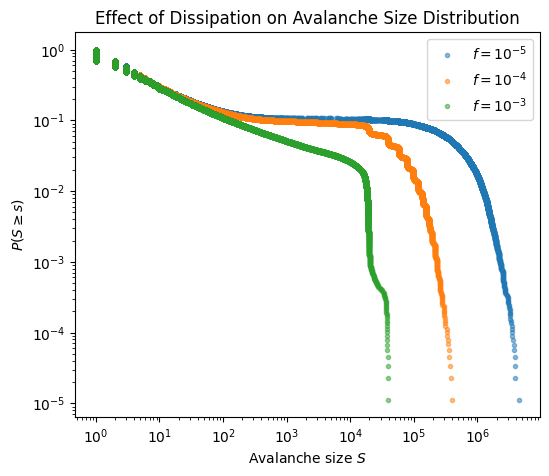

In [44]:
# ============================================================
# CCDF COMPARISON FOR DIFFERENT f
# ============================================================

plt.figure(figsize=(6,5))

for f_test in sorted(results_f.keys()):
    data = results_f[f_test]
    x, y = compute_ccdf(data)
    
    exponent = int(np.log10(f_test))
    label = rf"$f = 10^{{{exponent}}}$"
    
    plt.loglog(x, y, '.', alpha=0.5, label=label)



plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S \geq s)$")
plt.title("Effect of Dissipation on Avalanche Size Distribution")
plt.legend()

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig2.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [45]:
# ============================================================
# TAU ESTIMATION SENSITIVITY TEST
# ============================================================

s_min_test = 20

for s_max in [100, 150, 200, 300]:
    tau_val = estimate_tau_ccdf(sizes_filtered, s_min=s_min_test, s_max=s_max)
    print(f"s_min = {s_min_test}, s_max = {s_max}  ->  tau ≈ {tau_val:.3f}")


s_min = 20, s_max = 100  ->  tau ≈ 1.335
s_min = 20, s_max = 150  ->  tau ≈ 1.317
s_min = 20, s_max = 200  ->  tau ≈ 1.305
s_min = 20, s_max = 300  ->  tau ≈ 1.288


In [16]:
# ============================================================
# ERDOS-RENYI BASELINE TEST
# ============================================================

print("Building Erdős–Rényi network...")

mean_k = 4
p = mean_k / N   # same N defined globally

G_er = nx.erdos_renyi_graph(N, p, seed=seed)

degree_er = np.array([G_er.degree(i) for i in range(N)])

print("Mean degree:", degree_er.mean())
print("Isolated nodes:", (degree_er == 0).sum())
print("Degree-1 nodes:", (degree_er == 1).sum())
print("Maximum degree:", degree_er.max())

# Convert to CSR
indptr_er, indices_er, deg_er = graph_to_csr_undirected(G_er)
z_c_er = deg_er.astype(np.int32)

active_nodes_er = np.where(z_c_er > 0)[0].astype(np.int32)

print("Running ER simulation...")
t0 = time.time()

sizes_er, areas_er, losses_er = simulate_btw_fixed(
    indptr_er,
    indices_er,
    z_c_er,
    f,
    steps,
    transient,
    seed,
    active_nodes_er
)

print("Simulation completed in {:.2f} seconds".format(time.time() - t0))

sizes_er_filtered = sizes_er[sizes_er > 0]

print("Total avalanches:", len(sizes_er_filtered))
print("Max size:", sizes_er_filtered.max())
print("Mean size:", sizes_er_filtered.mean())


Building Erdős–Rényi network...
Mean degree: 3.9936
Isolated nodes: 350
Degree-1 nodes: 1453
Maximum degree: 14
Running ER simulation...
Simulation completed in 109.07 seconds
Total avalanches: 88416
Max size: 451913
Mean size: 5573.499174357582


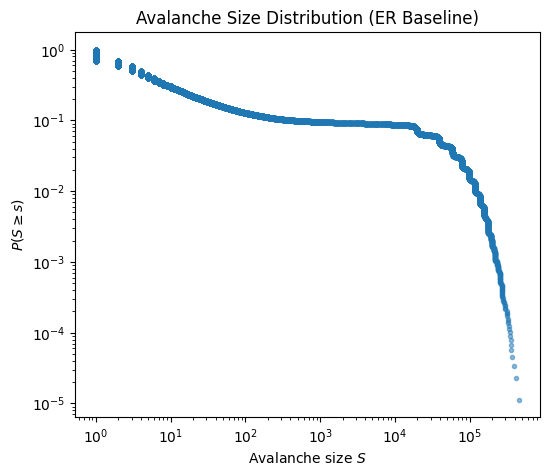

Estimated tau (ER): 1.3130408210393514


In [34]:
# ============================================================
# ER BASELINE CCDF
# ============================================================

x_er, y_er = compute_ccdf(sizes_er_filtered)

plt.figure(figsize=(6,5))
plt.loglog(x_er, y_er, '.', alpha=0.5)

plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S \geq s)$")
plt.title("Avalanche Size Distribution (ER Baseline)")

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig3.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

tau_er = estimate_tau_ccdf(sizes_er_filtered, s_min=20, s_max=200)
print("Estimated tau (ER):", tau_er)


Total avalanches: 88327
Bulk avalanches: 79354


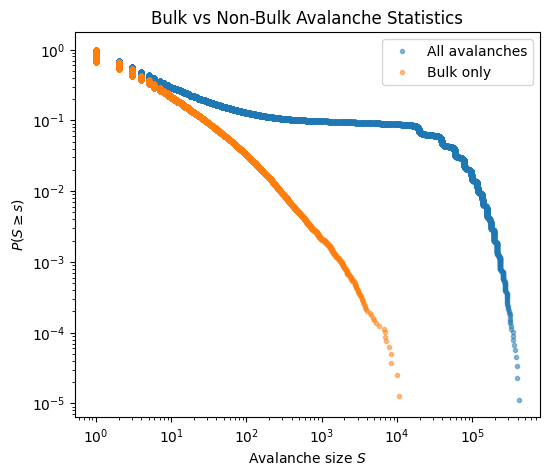

Tau (all avalanches): 1.3054227121705138
Tau (bulk only): 1.8949219005817581


In [35]:
# ============================================================
# BULK VS NON-BULK COMPARISON (APPENDIX)
# ============================================================

mask_nonzero = sizes > 0

sizes_all = sizes[mask_nonzero]
losses_all = losses[mask_nonzero]

sizes_bulk = sizes_all[losses_all == 0]

print("Total avalanches:", len(sizes_all))
print("Bulk avalanches:", len(sizes_bulk))


# ---- CCDF comparison ----

x_all, y_all = compute_ccdf(sizes_all)
x_bulk, y_bulk = compute_ccdf(sizes_bulk)

plt.figure(figsize=(6,5))

plt.loglog(x_all, y_all, '.', alpha=0.5, label="All avalanches")
plt.loglog(x_bulk, y_bulk, '.', alpha=0.5, label="Bulk only")

plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S \geq s)$")
plt.title("Bulk vs Non-Bulk Avalanche Statistics")
plt.legend()

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig_bulk.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


# ---- Tau comparison ----

tau_all = estimate_tau_ccdf(sizes_all, 20, 200)
tau_bulk = estimate_tau_ccdf(sizes_bulk, 20, 200)

print("Tau (all avalanches):", tau_all)
print("Tau (bulk only):", tau_bulk)


In [40]:
# ============================================================
# MULTI-GAMMA SIMULATIONS
# ============================================================

gamma_values = {
    "inf": float("inf"),
    "4.0": 4.0,
    "3.0": 3.0,
    "2.6": 2.6,
    "2.2": 2.2,
}


results_gamma = {}

for label, gamma_val in gamma_values.items():

    print("\n==============================")
    print(f"Running gamma = {label}")
    print("==============================")

    G_gamma = build_sf_static_model(N, m, gamma_val, seed + 1000 * (list(gamma_values.keys()).index(label) + 1))


    indptr_g, indices_g, degree_g = graph_to_csr_undirected(G_gamma)
    z_c_g = degree_g.astype(np.int32)

    active_nodes_g = np.where(z_c_g > 0)[0].astype(np.int32)

    t0 = time.time()

    sizes_g, areas_g, losses_g = simulate_btw_fixed(
        indptr_g,
        indices_g,
        z_c_g,
        f,
        steps,
        transient,
        seed,
        active_nodes_g
    )

    print("Simulation time:", time.time() - t0)

    sizes_g = sizes_g[sizes_g > 0]

    print("Total avalanches:", len(sizes_g))
    print("Max size:", sizes_g.max())

    results_gamma[label] = sizes_g


# Unpack results
sizes_inf = results_gamma["inf"]
sizes_30 = results_gamma["3.0"]
sizes_26 = results_gamma["2.6"]
sizes_22 = results_gamma["2.2"]
sizes_40 = results_gamma["4.0"]

print("\nAll gamma simulations completed.")



Running gamma = inf
Simulation time: 102.48196363449097
Total avalanches: 88297
Max size: 393370

Running gamma = 4.0
Simulation time: 108.49933099746704
Total avalanches: 93596
Max size: 598411

Running gamma = 3.0
Simulation time: 109.68527936935425
Total avalanches: 100750
Max size: 467574

Running gamma = 2.6
Simulation time: 115.14581990242004
Total avalanches: 108296
Max size: 643332

Running gamma = 2.2
Simulation time: 104.31077814102173
Total avalanches: 121365
Max size: 589330

All gamma simulations completed.


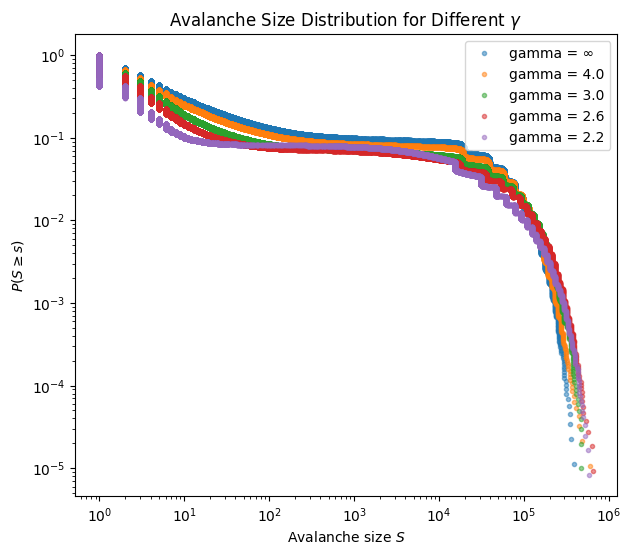

In [41]:
# ============================================================
# CCDF COMPARISON FOR DIFFERENT GAMMA
# ============================================================

plt.figure(figsize=(7,6))

for label, data in [
    ("gamma = ∞", sizes_inf),
    ("gamma = 4.0", sizes_40),
    ("gamma = 3.0", sizes_30),
    ("gamma = 2.6", sizes_26),
    ("gamma = 2.2", sizes_22),
]:
    x, y = compute_ccdf(data)
    plt.loglog(x, y, '.', alpha=0.5, label=label)

plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S \geq s)$")
plt.title("Avalanche Size Distribution for Different $\gamma$")
plt.legend()

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig_gamma_ccdf.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


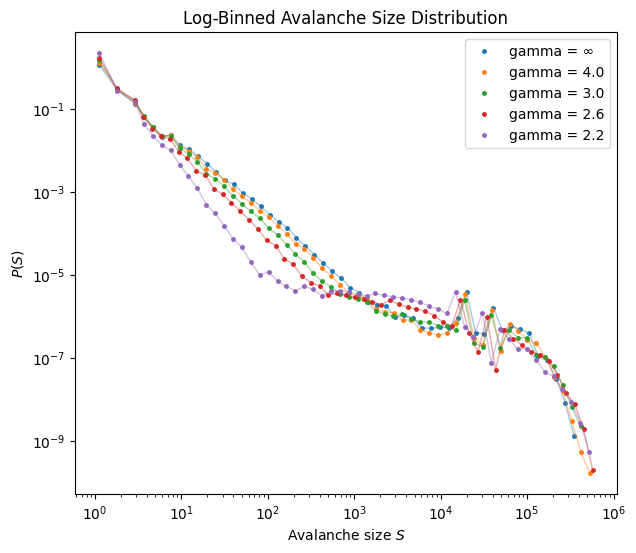

In [69]:
# ============================================================
# LOG-BINNED PDF COMPARISON
# ============================================================
def logbin_pdf(data, bins_per_decade=8):

    data = data[data > 0]

    min_val = data.min()
    max_val = data.max()

    bins = np.logspace(
        np.log10(min_val),
        np.log10(max_val),
        int((np.log10(max_val) - np.log10(min_val)) * bins_per_decade)
    )

    hist, edges = np.histogram(data, bins=bins, density=True)

    centers = np.sqrt(edges[:-1] * edges[1:])

    mask = hist > 0

    return centers[mask], hist[mask]

plt.figure(figsize=(7,6))

for label, data in [
    ("gamma = ∞", sizes_inf),
    ("gamma = 4.0", sizes_40),
    ("gamma = 3.0", sizes_30),
    ("gamma = 2.6", sizes_26),
    ("gamma = 2.2", sizes_22),
]:
    x, pdf = logbin_pdf(data, bins_per_decade=10)
    line = plt.loglog(x, pdf, 'o', markersize=2.5, label=label)
    color = line[0].get_color()

    plt.loglog(x, pdf, '-', linewidth=1.0, color=color, alpha=0.4)

    
plt.xlabel("Avalanche size $S$")
plt.ylabel(r"$P(S)$")
plt.title("Log-Binned Avalanche Size Distribution")
plt.legend()

plt.savefig(
    r"C:\Users\chiar\OneDrive\Desktop\Magistrale\manlio\project_15\latex_15\fig_gamma_pdf.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [77]:
# ============================================================
# MANUAL EXPONENT ESTIMATION (CCDF) WITH CUSTOM WINDOWS
# ============================================================

import numpy as np
from scipy.stats import linregress

def estimate_tau_ccdf_with_r2(data, s_min, s_max):
    """
    Estimate avalanche exponent tau from the CCDF in a
    manually selected scaling window and compute R^2.

    Parameters
    ----------
    data : array-like
        Avalanche size data (positive values).
    s_min : float
        Lower bound of fitting window.
    s_max : float
        Upper bound of fitting window.

    Returns
    -------
    tau : float
        Estimated exponent.
    r2 : float
        Coefficient of determination of the fit.
    n_points : int
        Number of points used in the fit.
    """

    data = data[data > 0]

    x = np.sort(data)
    n = len(x)
    y = (n - np.arange(n)) / n

    mask = (x >= s_min) & (x <= s_max)

    if mask.sum() < 10:
        return np.nan, np.nan, mask.sum()

    logx = np.log10(x[mask])
    logy = np.log10(y[mask])

    slope, intercept, r_value, _, _ = linregress(logx, logy)

    tau = 1 - slope
    r2 = r_value**2

    return tau, r2, mask.sum()


# ------------------------------------------------------------
# Define custom windows for each gamma
# (You can modify these values manually)
# ------------------------------------------------------------

fit_windows = {
    "inf":  (20, 200),
    "4.0":  (20, 200),
    "3.0":  (20, 180),
    "2.6":  (50, 100),
    "2.2":  (40, 80),
}

gamma_data = {
    "inf": sizes_inf,
    "4.0": sizes_40,
    "3.0": sizes_30,
    "2.6": sizes_26,
    "2.2": sizes_22,
}

print("Manual CCDF exponent estimation:\n")

for label in ["inf", "4.0", "3.0", "2.6", "2.2"]:

    s_min, s_max = fit_windows[label]

    tau, r2, n_points = estimate_tau_ccdf_with_r2(
        gamma_data[label],
        s_min,
        s_max
    )

    print(f"gamma = {label}")
    print(f"  window = [{s_min}, {s_max}]")
    print(f"  tau ≈ {tau:.3f}")
    print(f"  R^2 = {r2:.4f}")
    print(f"  points used = {n_points}")
    print()


Manual CCDF exponent estimation:

gamma = inf
  window = [20, 200]
  tau ≈ 1.303
  R^2 = 0.9893
  points used = 9647

gamma = 4.0
  window = [20, 200]
  tau ≈ 1.299
  R^2 = 0.9851
  points used = 8284

gamma = 3.0
  window = [20, 180]
  tau ≈ 1.273
  R^2 = 0.9733
  points used = 5900

gamma = 2.6
  window = [50, 100]
  tau ≈ 1.137
  R^2 = 0.9900
  points used = 824

gamma = 2.2
  window = [40, 80]
  tau ≈ 1.023
  R^2 = 0.9650
  points used = 152



 #γ	 vs τ teorico
∞	1.500
4.0	1.500
3.0	~1.500 
2.6	2.6/1.6 = 1.625
2.2	2.2/1.2 = 1.833